```markdown
MACHINE LEARNING EMG PROJECT
```
``
Project Workflow
``
`
Data pre-processing
`
Feature Design
`
Develelopment of Models
`
Training
`

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

from tabulate import tabulate

#  Data Cleaning

In [3]:
#readin in the data
df = pd.read_csv('Project_Data_EE4C12_S&S_EMG.csv')
classes=np.array([
    'unmarked data',
    'hand at rest',
    'hand clenched in a fist',
    'wrist flexion',
    'wrist extension',
    'radial deviations',
    'ulnar deviations',
    'extended palm'
])

print(df.head())
print(df.shape)
num_samples = df.shape[0]



   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  class  label  
0  -0.00001      0      1  
1  -0.00001      0      1  
2   0.00001      0      1  
3   0.00001      0      1  
4   0.00001      0      1  
(4237907, 11)


`
check for n/a values
`

In [4]:
na_counts = df.isna().sum()
display(na_counts.T)

time        0
channel1    0
channel2    0
channel3    0
channel4    0
channel5    0
channel6    0
channel7    0
channel8    0
class       0
label       0
dtype: int64

In [5]:

print("There are " + str(df['label'].nunique()) + " unique subjects in the dataset (different people performing the gestures).")
grouped_df = df.groupby(['label', 'class']).size().unstack(fill_value=0)
display(grouped_df.T)

There are 36 unique subjects in the dataset (different people performing the gestures).


label,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
class,,,,,,,,,,,,,,,,,,,,,
0,78682,94654,67770,72578,68057,61128,82641,80264,90407,81875,...,64660,64522,64093,98180,53642,75148,73298,85693,60383,65538
1,7311,7140,6443,6471,6506,5814,7523,6468,7083,7690,...,7167,5232,6317,8047,6924,6650,7082,7553,6703,6391
2,6806,6777,6301,6598,6806,6243,7651,6537,6019,6571,...,6686,5628,6460,7279,5975,8085,6316,7458,6247,6093
3,7329,6815,6486,6875,6874,6663,8383,5939,5838,6534,...,6654,5488,7495,7480,6197,8271,6127,7274,6422,6078
4,6824,6812,6421,7193,6724,6688,8923,6027,5776,6766,...,7309,5733,7059,7061,6180,8386,6527,7732,6653,5926
5,7075,6856,6278,7423,6098,7094,8414,6237,6050,6658,...,7405,5245,7261,6700,6028,8604,6225,7710,6897,5743
6,7143,7372,6086,7060,6183,5989,9105,6476,6474,6995,...,6918,5918,7302,7223,6077,7786,6530,7782,6196,5985
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6591,0,0,0,0,0,0


Percentage of samples for each class relative to the total number of samples:

Percentage of samples for class 0 relative to the total number of samples: 64.30%
Percentage of samples for class 1 relative to the total number of samples: 5.90%
Percentage of samples for class 2 relative to the total number of samples: 5.74%
Percentage of samples for class 3 relative to the total number of samples: 5.89%
Percentage of samples for class 4 relative to the total number of samples: 5.94%
Percentage of samples for class 5 relative to the total number of samples: 5.94%
Percentage of samples for class 6 relative to the total number of samples: 5.97%
Percentage of samples for class 7 relative to the total number of samples: 0.32%


Number of nonzero elements for class 7: 2, for patients (array([10, 29]),)


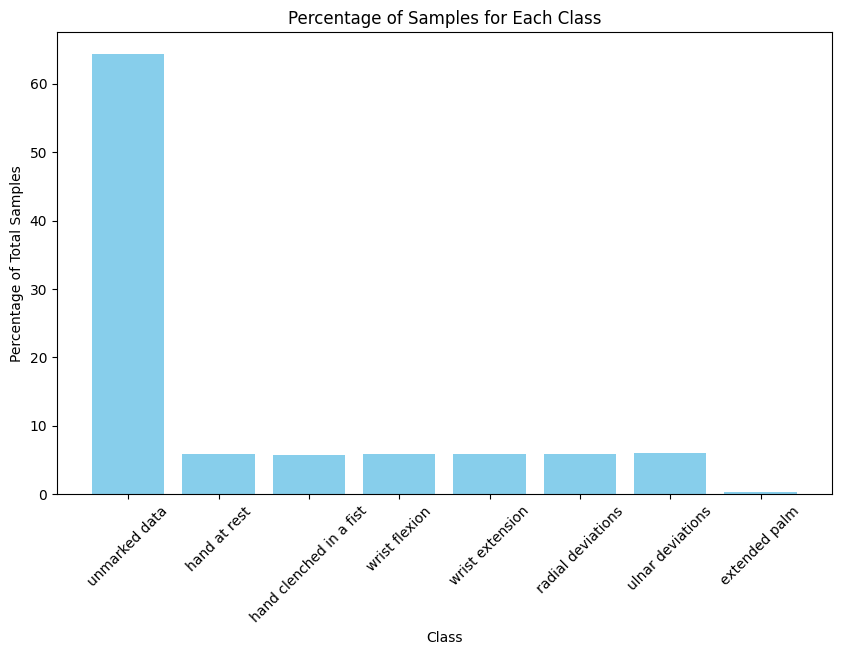

In [6]:
nonzero_count = np.count_nonzero(grouped_df.T.iloc[7])
print(f"Percentage of samples for each class relative to the total number of samples:\n")
for i in range(8):
    nonzero_count = np.count_nonzero(grouped_df.T.iloc[i])
    print(f"Percentage of samples for class {i} relative to the total number of samples: {np.sum(grouped_df.T.iloc[i])/num_samples*100:.2f}%")

print(f"\n\nNumber of nonzero elements for class {i}: {nonzero_count}, for patients {np.nonzero(grouped_df.T.iloc[7])}")

# Calculate the percentages
percentages = [np.sum(grouped_df.T.iloc[i]) / num_samples * 100 for i in range(8)]
# Plot the percentages
plt.figure(figsize=(10, 6))
plt.bar(classes[:8], percentages, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Percentage of Total Samples')
plt.title('Percentage of Samples for Each Class')
plt.xticks(rotation=45)
plt.show()


`
Due to the limited information available on class 7 it was decided that we would only classify on the first 6 classes
`

1499054
Percentage of samples for class 0 relative to the total number of samples: 16.68%
Percentage of samples for class 1 relative to the total number of samples: 16.22%
Percentage of samples for class 2 relative to the total number of samples: 16.64%
Percentage of samples for class 3 relative to the total number of samples: 16.78%
Percentage of samples for class 4 relative to the total number of samples: 16.79%
Percentage of samples for class 5 relative to the total number of samples: 16.88%


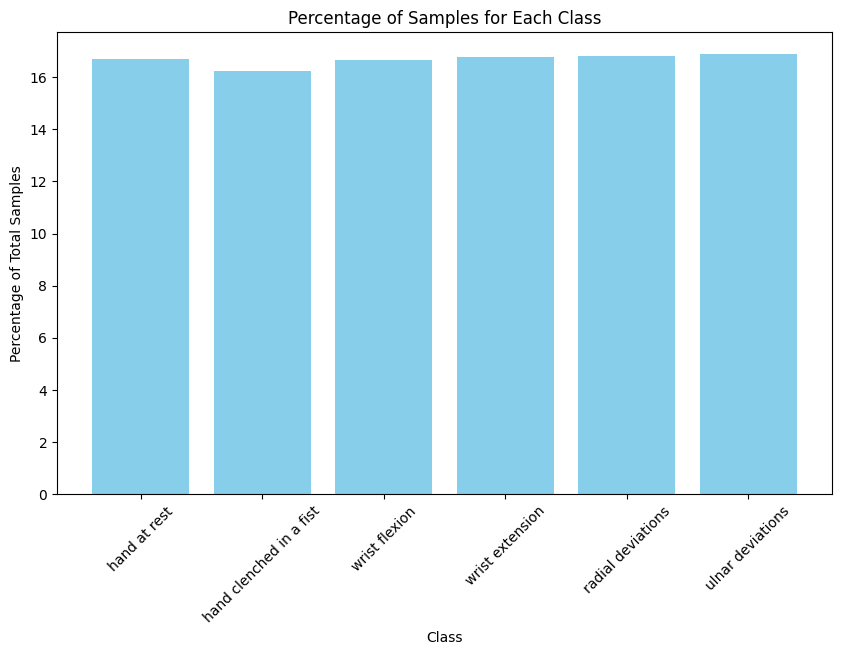

In [7]:

df_preprocessed = df[df['class'] != 7]
df_preprocessed = df_preprocessed[df_preprocessed['class'] != 0]
num_samples_processed = df_preprocessed.shape[0]
print(num_samples_processed)
grouped_df_preprocess = df_preprocessed.groupby([ 'class']).size()
classes_preprocessed = classes[1:7]
for i in range(6):
    # nonzero_count = np.count_nonzero(grouped_df_preprocess.T.iloc[i])
  
    print(f"Percentage of samples for class {i} relative to the total number of samples: {(grouped_df_preprocess.T.iloc[i])/num_samples_processed*100:.2f}%")

#  Calculate the percentages
percentages = [np.sum(grouped_df_preprocess.T.iloc[i]) / num_samples_processed * 100 for i in range(0,6)]
# Plot the percentages
plt.figure(figsize=(10, 6))
plt.bar(classes_preprocessed, percentages, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Percentage of Total Samples')
plt.title('Percentage of Samples for Each Class')
plt.xticks(rotation=45)
plt.show()

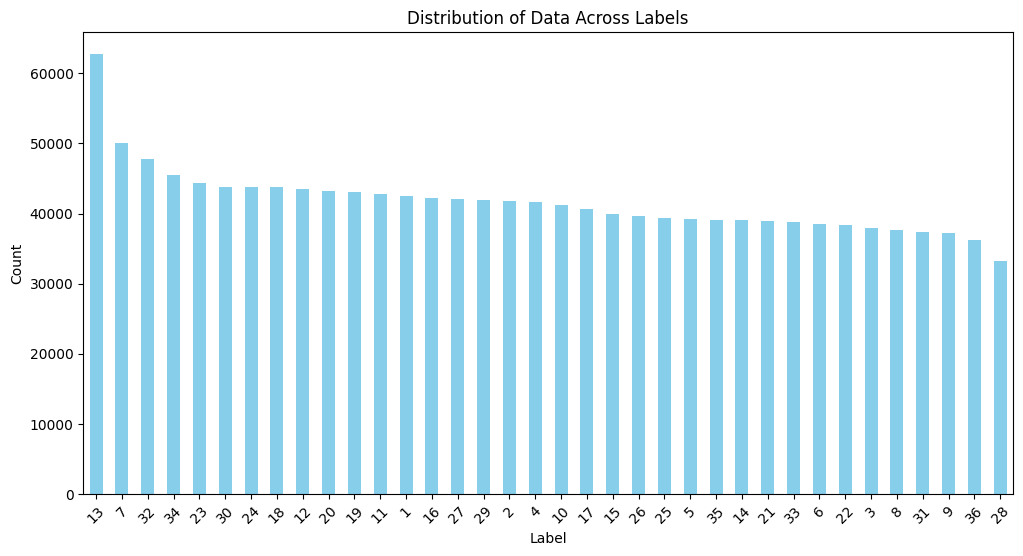

In [8]:
# Count the occurrences of each label
label_counts = df_preprocessed['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Data Across Labels')
plt.xticks(rotation=45)
plt.show()

``
Lets us visualise the data
``

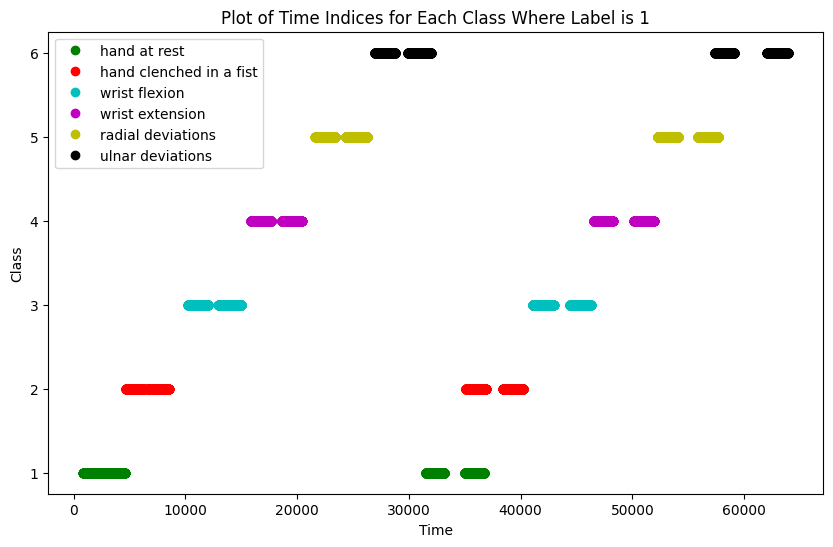

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
64012,880,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64013,881,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64014,882,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64015,883,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64016,884,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4397,4576,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1
4398,4577,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1
4399,4578,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1
4400,4579,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1


In [9]:
# Define the colors for each class
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate through each class and plot the markers
for class_value in range(1,7,1):  # Classes are labeled from 0 to 7
    subset = df_preprocessed[(df_preprocessed['label'] == 1) & (df_preprocessed['class'] == class_value) ]#& (df_preprocessed['time'] > 33000)
    plt.plot(subset['time'], subset['class'], 'o', label=f'Class {class_value}', color=colors[class_value])

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Class')
plt.title('Plot of Time Indices for Each Class Where Label is 1')
plt.legend(classes_preprocessed)
plt.show()


subset = df_preprocessed[(df_preprocessed['label'] == 1) & (df_preprocessed['class'] == 1) & (df_preprocessed['time'] < 10000)]
subset = subset.sort_values(by='time')
subset

# Feature extraction/selection

### Window each gesture 
#### separate gestures if there is a gap in time

In [10]:
#loop through 36 labels (subjects)
#separate dataframe parts based on the 6 classes, 
# separate gesture data if there is a time gap between data (empty space)
# save the data in a dictionary with the label and class as the key

# Initialize an empty dictionary to store the separated data
data_dict = {}

# Define the time gap threshold (adjust as needed)
time_gap_threshold = 70000  # Example threshold

# Loop through each label (subject)
for label in range(1,37):
    # Loop through each class
    for class_value in range(1,7,1):
        # Filter the DataFrame for the current label and class
        subset = df_preprocessed[(df_preprocessed['label'] == label) & (df_preprocessed['class'] == class_value)]
        
        # Sort by time to ensure proper segmentation
        subset = subset.sort_values(by='time')
        
        # Identify segments of data where there is a time gap
        segments = []
        current_segment = []
        previous_time = None
        
        for _, row in subset.iterrows():
            current_time = row['time']
            if previous_time is not None and (current_time - previous_time) > time_gap_threshold:
                # Save the current segment and start a new one
                if current_segment:
                    segments.append(pd.DataFrame(current_segment))
                current_segment = []
            current_segment.append(row)
            previous_time = current_time
        
        # Add the last segment if it exists
        if current_segment:
            segments.append(pd.DataFrame(current_segment))
        # if len(segments)!=2:
        #     print(label, class_value,"  segment length is:",len(segments))
        # Save the segments in the dictionary with the label and class as the key
        # Drop the 'time' column from each segment
        # segments = [segment.drop(columns=['time']) for segment in segments]
        
        # Save the segments in the dictionary with the label and class as the key
        data_dict[(label, class_value)] = segments

# data_dict now contains the separated data for each label and class

In [11]:

# Initialize an empty list to store the new data with features
new_data = []

# Define the window size and step size (50% overlap)
window_size = 250
step_size = int(window_size*0.5)

# Function to calculate waveform length
def waveform_length(window):
    return np.sum(np.abs(np.diff(window, axis=0)), axis=0)


def zero_crossing_rate(window):
    return np.sum(np.diff(np.sign(window), axis=0) != 0, axis=0)

def peak_frequency(window):
    freq_domain = np.fft.fft(window, axis=0)
    freqs = np.fft.fftfreq(window.shape[0])
    peak_freqs = freqs[np.argmax(np.abs(freq_domain), axis=0)]
    return peak_freqs

# Loop through each label (subject)
for label in range(1, 37):
    # Loop through each class
    for class_value in range(1, 7):
        for i, segment in enumerate(data_dict[(label, class_value)]):
            # Loop through the segment with the defined window and step size
            for start in range(0, len(segment) - window_size + 1, step_size):
                window = segment.iloc[start:start + window_size]
                # Calculate features for each channel
                min_values = window.min()
                max_values = window.max()
                mean_abs_values = window.abs().mean()
                wave_lengths = waveform_length(window)
                variance_values = window.var()
               
                zero_crossings = zero_crossing_rate(window)
                std_values = window.std()
                skew_values = window.skew()
                kurt_values = window.kurtosis()
                peak_freqs = peak_frequency(window)
                mean_freq_values = np.mean(np.abs(np.fft.fft(window, axis=0)), axis=0)

                # Create a dictionary to store the features for each channel
                features = {}
                for channel in range(1, 9):
                    features[f'ch{channel}_std_value'] = std_values[channel]
                    features[f'ch{channel}_skew_value'] = skew_values[channel]
                    features[f'ch{channel}_kurt_value'] = kurt_values[channel]
                    features[f'ch{channel}_variance'] = variance_values[channel]

                    features[f'ch{channel}_min_value'] = min_values[channel]
                    features[f'ch{channel}_max_value'] = max_values[channel]
                    features[f'ch{channel}_mean_abs_value'] = mean_abs_values[channel]
                    features[f'ch{channel}_wave_length'] = wave_lengths[channel]
                    features[f'ch{channel}_zero_crossing'] = zero_crossings[channel]
                    
                    
                    features[f'ch{channel}_peak_freq'] = peak_freqs[channel]
                    features[f'ch{channel}_mean_freq_value'] = mean_freq_values[channel]
                    
      
                
                # Add class and label to the features
                features['class'] = class_value
                features['label'] = label
                # features['gesture_time'] = start
                
                # Append the features dictionary to the list
                new_data.append(features)

# Convert the list of dictionaries to a DataFrame
X = pd.DataFrame(new_data)

# final_df now contains the new data with features and the associated class and label

/var/folders/k8/4y401hn12tqg8hyrx_zfp3zw0000gn/T/ipykernel_1208/1240946407.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_std_value'] = std_values[channel]
/var/folders/k8/4y401hn12tqg8hyrx_zfp3zw0000gn/T/ipykernel_1208/1240946407.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_skew_value'] = skew_values[channel]
/var/folders/k8/4y401hn12tqg8hyrx_zfp3zw0000gn/T/ipykernel_1208/1240946407.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [12]:
# Define the feature names (12 feature groups, each with 8 channels)
feature_names = [
    '_min_value',
    '_max_value',
    '_mean_abs_value',
    '_wave_length',
    '_zero_crossing',
    '_second_moment', 
    '_skew_value', 
    '_kurt_value', 
    '_var_value', 
    '_std_value',
    '_peak_freq', 
    '_mean_freq_value'
]



# Create feature_group2 by removing one feature at a time
feature_group1 = []
for feature in feature_names:
    group = [f for f in feature_names if f != feature] + ['label']
    feature_group1.append(group)

# Define a new feature group by removing specific features
feature_group2= [[
    '_min_value',
    '_max_value',
    '_mean_abs_value',
    '_skew_value',
    '_variance',
    '_std_value',
    '_mean_freq_value', 'label'
]]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_standardized = scaler.fit_transform(X.drop(columns=['class', 'label']))

# Define the target variable
y = X['class']

# # Split the data into training and testing sets
y_train = y[X['label'] < 30]
y_test = y[X['label'] >= 30]
X_train = X_standardized[X['label'] < 30]
X_test = X_standardized[X['label'] >= 30]

# Initialize a list to store the results
results = []

# Train and evaluate the SVM model with all features (baseline)
svm_model = SVC(kernel='rbf', tol=1e-4, C=1)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
results.append({
    'included_feature': 'All',
    'feature_group': 'All',
    'accuracy': accuracy,
    'classification_report': report
})

# Loop through each feature group and evaluate the SVM model
for group_name, feature_group in zip(['Group 1', 'Group 2'], [feature_group1, feature_group2]):
    for i, features_i in enumerate(feature_group):
        print(f"Evaluating feature group {i+1} in {group_name}")
        
        # Select the features including the current group
        X_subset = X[[col for col in X.columns if any(included_features in col for included_features in features_i)]]
        X_train_subset = X_subset[X_subset['label'] < 30]
        X_test_subset = X_subset[X_subset['label'] >= 30]
        X_train_subset = X_train_subset.drop(columns=['label'])
        X_test_subset = X_test_subset.drop(columns=['label'])
        
        # Standardize the subset of features
        X_train_subset = scaler.fit_transform(X_train_subset)
        X_test_subset = scaler.transform(X_test_subset)

        # Train and evaluate the SVM model
        svm_model = SVC(kernel='rbf', tol=1e-4, C=1)
        svm_model.fit(X_train_subset, y_train)
        y_pred = svm_model.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Store the results
        results.append({
            'included_feature': features_i,
            'feature_group': group_name,
            'accuracy': accuracy,
            'classification_report': report
        })

# Convert the results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)


Evaluating feature group 1 in Group 1
Evaluating feature group 2 in Group 1
Evaluating feature group 3 in Group 1
Evaluating feature group 4 in Group 1
Evaluating feature group 5 in Group 1
Evaluating feature group 6 in Group 1
Evaluating feature group 7 in Group 1
Evaluating feature group 8 in Group 1
Evaluating feature group 9 in Group 1
Evaluating feature group 10 in Group 1
Evaluating feature group 11 in Group 1
Evaluating feature group 12 in Group 1
Evaluating feature group 1 in Group 2


In [13]:
# Display the results sorted by accuracy
results_df_sorted = results_df.sort_values(by='accuracy', ascending=False)

# Convert the DataFrame to a list of lists for tabulate
results_list = results_df_sorted[['included_feature', 'accuracy']].values.tolist()

# Print the results using tabulate
print(tabulate(results_list, headers=['Included Feature', 'Accuracy'], tablefmt='grid'))

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
| Included Feature                                                                                                                                                                           |   Accuracy |
+============================================================================================================================================================================================+============+
| ['_min_value', '_max_value', '_mean_abs_value', '_skew_value', '_variance', '_std_value', '_mean_freq_value', 'label']                                                                     |   0.857079 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
# # Initialize the StandardScaler
scaler = StandardScaler()

# # Fit and transform the data
final_features=['_min_value', '_max_value', '_mean_abs_value', '_skew_value', '_variance', '_std_value', '_mean_freq_value', 'label'] 

X_subset = X[[col for col in X.columns if any(included_features in col for included_features in final_features )]]


np.random.seed(1)  # For reproducibility
all_labels = np.unique(X['label'])
train_labels = np.random.choice(all_labels, 30, replace=False)
test_labels = np.setdiff1d(all_labels, train_labels)

# Assign the labels to the respective sets
y=X['class']
y_train = y[X_subset['label'].isin(train_labels)]
y_test = y[X_subset['label'].isin(test_labels)]

X_train = X_subset[X_subset['label'].isin(train_labels)]
X_test = X_subset[X_subset['label'].isin(test_labels)]


# Split the data into training, validation, and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.4, random_state=1, stratify=y)


# Standardize the subset of features
X_train = scaler.fit_transform(X_train.drop(columns=['label']))
X_test = scaler.fit_transform(X_test.drop(columns=['label']))
print(X_train.shape)
print(X_test.shape)

# Calculate and print the percentages
train_percentage = len(X_train) / len(X_subset) * 100
test_percentage = len(X_test) / len(X_subset) * 100

print(f"Training set percentage: {train_percentage:.2f}%")
print(f"Test set percentage: {test_percentage:.2f}%")

(9601, 56)
(2069, 56)
Training set percentage: 82.27%
Test set percentage: 17.73%



# Model selection/implementation


In [15]:
def test_model(model, x_train, y_train, x_test, y_test):
    y_pred = model.predict(x_test)
    print('===Testing results===')
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Recall: {:.3f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('F1 score: {:.3f}'.format(f1_score(y_test, y_pred, average='weighted')))
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report) 


## Grid search for hyperparameter tuning


In [16]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [17]:
# KNN parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

print(f"=== Performing Grid Search for KNN ===")
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)
print(f"Best parameters: {grid_search_knn.best_params_}")
print(f"Test accuracy: {grid_search_knn.score(X_test, y_test)}")  

=== Performing Grid Search for KNN ===


Best parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Test accuracy: 0.8675688738521025


In [18]:
# SVM parameter grid for different kernels
svm_param_grid = {
'linear': {
    'C': [0.01, 0.1, 1, 10, 100],
    'tol': [1e-4],
    'class_weight': [None, 'balanced']
},
'rbf': {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'auto', 'scale'],
    'tol': [1e-4],
    'class_weight': [None, 'balanced']
},
'poly': {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'auto', 'scale'],
    'degree': [2, 3, 4],
    'coef0': [0, 0.1, 0.5],  # Only used in polynomial and sigmoid kernels
    'tol': [1e-4],
    'class_weight': [None, 'balanced']
}
}

print(f"=== Performing Grid Search for SVM ===")
for kernel, param_grid in svm_param_grid.items():
    print(f"Kernel: {kernel}")
    svm = SVC(kernel=kernel)
    grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search_svm.fit(X_train, y_train)
    print(f"Best parameters: {grid_search_svm.best_params_}")
    print(f"Test accuracy: {grid_search_svm.score(X_test, y_test)}")  

=== Performing Grid Search for SVM ===
Kernel: linear
Best parameters: {'C': 0.1, 'class_weight': None, 'tol': 0.0001}
Test accuracy: 0.9284678588690188
Kernel: rbf
Best parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'tol': 0.0001}
Test accuracy: 0.9072015466408894
Kernel: poly
Best parameters: {'C': 10, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 3, 'gamma': 'scale', 'tol': 0.0001}
Test accuracy: 0.9076848719188013


In [24]:
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (100, 50), (150, 100, 50)],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'batch_size': [32, 64, 128],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Use RandomizedSearchCV to explore a random subset of the parameter grid
print(f"=== Performing Grid Search for MLP ===")
mlp = MLPClassifier(max_iter=300, random_state=42)
random_search_mlp = RandomizedSearchCV(mlp, mlp_param_grid, n_iter=30, cv=5, scoring='accuracy', random_state=42)
random_search_mlp.fit(X_train, y_train)

print(f"Best parameters: {random_search_mlp.best_params_}")
print(f"Test accuracy: {random_search_mlp.score(X_test, y_test)}")   

=== Performing Grid Search for MLP ===
Best parameters: {'solver': 'sgd', 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'batch_size': 32, 'alpha': 0.01, 'activation': 'tanh'}
Test accuracy: 0.9043015949734171



## KNN


Model with 9 neighbors saved as models/knn_9_neighbors_2.pkl

===Testing results===
Accuracy: 0.868
Precision: 0.869
Recall: 0.868
F1 score: 0.867
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.99       338
           2       0.93      0.91      0.92       321
           3       0.80      0.71      0.75       346
           4       0.83      0.92      0.87       348
           5       0.91      0.82      0.86       354
           6       0.78      0.85      0.82       362

    accuracy                           0.87      2069
   macro avg       0.87      0.87      0.87      2069
weighted avg       0.87      0.87      0.87      2069



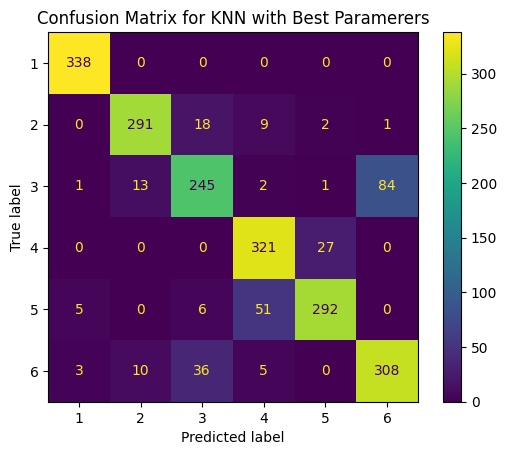

In [16]:
# Define the directory and base filename
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

n_neighbors = 9 # Best parameter from Grid Search
# Initialize the KNN model with the specified number of neighbors
knn_model = KNeighborsClassifier(algorithm='auto', n_neighbors=n_neighbors, p=1, weights='uniform')

# Fit the model
knn_model.fit(X_train, y_train)

#Prepare the model filename with n_neighbors
version = 1
while True:
    model_filename = f"knn_{n_neighbors}_neighbors_{version}.pkl"
    model_path = os.path.join(model_dir, model_filename)
    if not os.path.exists(model_path):
        break
    version += 1
    
# Save the model
with open(model_path, 'wb') as f:
    pickle.dump({'model': knn_model}, f)
print(f"Model with {n_neighbors} neighbors saved as {model_path}\n")

# Test the model
test_model(knn_model,X_train,y_train,X_test,y_test)

#Plot the confusion matrix for testing set
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test)
plt.title(f'Confusion Matrix for KNN with Best Paramerers')
plt.savefig("task2_cm_knn.png", bbox_inches='tight')
plt.show()

# Validate the model
#validate_model(knn_model,X_val,y_val)

#Plot the confusion matrix for validation set
# ConfusionMatrixDisplay.from_estimator(knn_model, X_val, y_val)
# plt.title(f'Confusion Matrix for KNN with {n_neighbors} Neighbors (Validation Set)')
# plt.show()


## SVM


Model with linear kernel saved as models/linear_svm_6.pkl

kernel: linear
C: 0.1
class_weight: None
tol: 0.0001


===Testing results===
Accuracy: 0.928
Precision: 0.929
Recall: 0.928
F1 score: 0.928
Classification Report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       338
           2       0.89      0.94      0.92       321
           3       0.88      0.86      0.87       346
           4       0.93      0.96      0.94       348
           5       0.96      0.91      0.93       354
           6       0.92      0.90      0.91       362

    accuracy                           0.93      2069
   macro avg       0.93      0.93      0.93      2069
weighted avg       0.93      0.93      0.93      2069



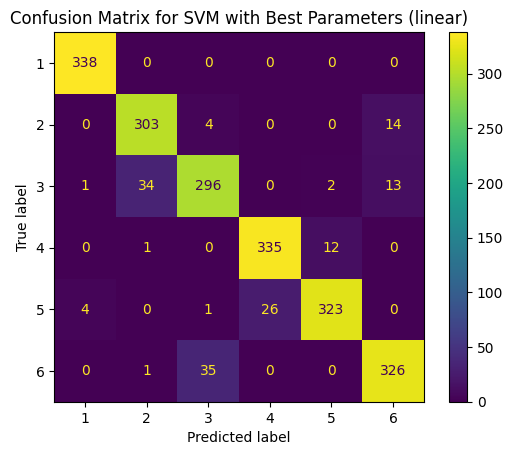

Model with rbf kernel saved as models/rbf_svm_6.pkl

kernel: rbf
gamma: auto
C: 10
class_weight: balanced
tol: 0.0001


===Testing results===
Accuracy: 0.907
Precision: 0.907
Recall: 0.907
F1 score: 0.907
Classification Report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       338
           2       0.93      0.90      0.91       321
           3       0.82      0.82      0.82       346
           4       0.91      0.94      0.92       348
           5       0.93      0.90      0.91       354
           6       0.88      0.89      0.89       362

    accuracy                           0.91      2069
   macro avg       0.91      0.91      0.91      2069
weighted avg       0.91      0.91      0.91      2069



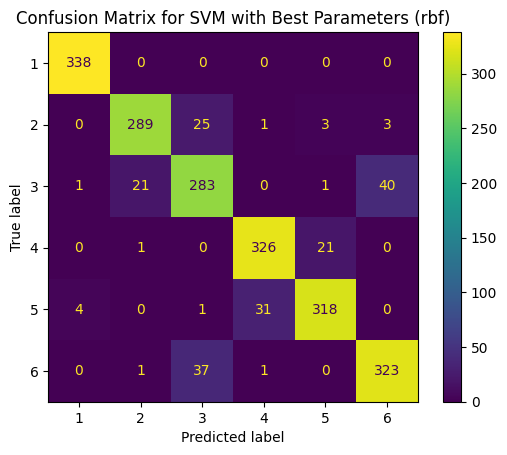

Model with poly kernel saved as models/poly_svm_6.pkl

kernel: poly
degree: 3
gamma: scale
C: 10
coef0: 0.1
class_weight: balanced
tol: 0.0001


===Testing results===
Accuracy: 0.908
Precision: 0.908
Recall: 0.908
F1 score: 0.908
Classification Report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       338
           2       0.92      0.91      0.92       321
           3       0.83      0.84      0.84       346
           4       0.93      0.90      0.91       348
           5       0.90      0.90      0.90       354
           6       0.88      0.89      0.89       362

    accuracy                           0.91      2069
   macro avg       0.91      0.91      0.91      2069
weighted avg       0.91      0.91      0.91      2069



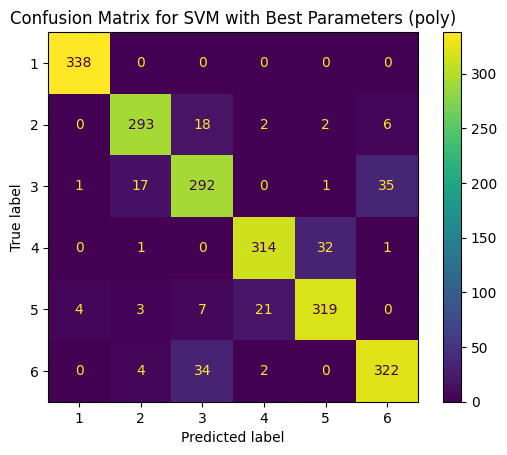

In [19]:
# Define the different kernels with their corresponding hyperparameters
svm_param_grid = [
    {'kernel': 'linear', 'C': 0.1, 'class_weight': None, 'tol': 1e-4}, 
    {'kernel': 'rbf', 'gamma': 'auto', 'C': 10, 'class_weight': 'balanced', 'tol': 1e-4}, 
    {'kernel': 'poly', 'degree': 3, 'gamma': 'scale', 'C': 10, 'coef0': 0.1, 'class_weight': 'balanced', 'tol': 1e-4}
]

# Iterate over each parameter grid
for param_grid in svm_param_grid:
    # Initialize the SVM model with the kernel and its parameters from the param_grid
    svm_model = SVC(**param_grid)
    
    # Fit the model
    svm_model.fit(X_train, y_train)
    
    # Prepare the model filename with kernel name
    kernel = param_grid['kernel']
    version = 1
    while True:
        model_filename = f"{kernel}_svm_{version}.pkl"
        model_path = os.path.join(model_dir, model_filename)
        if not os.path.exists(model_path):
            break
        version += 1

    # Save the model
    with open(model_path, 'wb') as f:
        pickle.dump({'model': svm_model}, f)

    print(f"Model with {kernel} kernel saved as {model_path}\n")

     # Print the kernel name and hyperparameters
    for key, value in param_grid.items():
        print(f"{key}: {value}")
    print("\n")

    # Test the model
    test_model(svm_model,X_train,y_train,X_test,y_test)

    #Plot the confusion matrix for testing set
    ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test)
    plt.title(f'Confusion Matrix for SVM with Best Parameters ({kernel})')
    plt.savefig(f"task2_cm_svm_{kernel}.png", bbox_inches='tight')
    plt.show()   

    # Validate the model
    # validate_model(svm_model,X_val,y_val)
    
    #Plot the confusion matrix for validation set
    # ConfusionMatrixDisplay.from_estimator(svm_model, X_val, y_val)
    # plt.title(f'Confusion Matrix for SVM with {kernel} Kernel (Validation Set)')
    # plt.show()   



## MLP


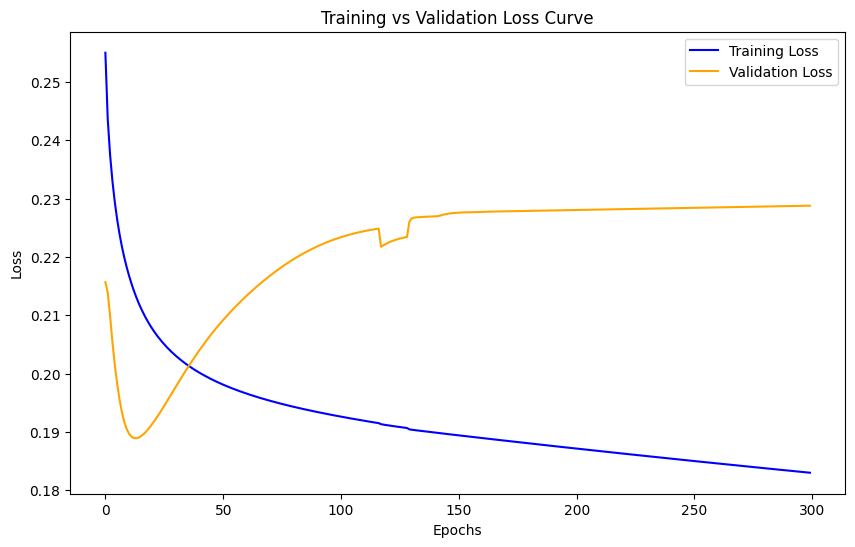

Model saved as models/mlp_7.pkl

===Testing results===
Accuracy: 0.906
Precision: 0.906
Recall: 0.906
F1 score: 0.905
Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       338
           2       0.95      0.89      0.92       321
           3       0.81      0.78      0.80       346
           4       0.91      0.97      0.94       348
           5       0.95      0.90      0.93       354
           6       0.85      0.89      0.87       362

    accuracy                           0.91      2069
   macro avg       0.91      0.91      0.91      2069
weighted avg       0.91      0.91      0.91      2069



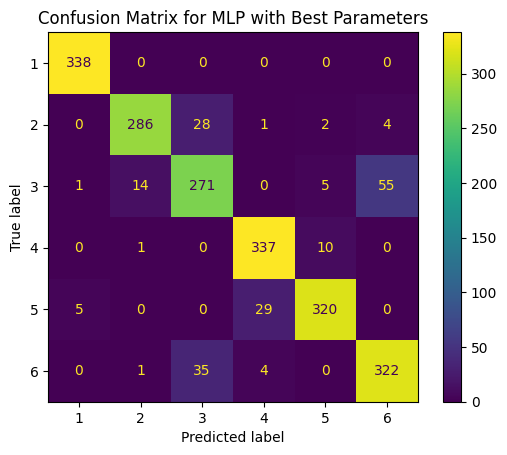

In [22]:
# Initialize MLPClassifier parameters
mlp_model = MLPClassifier(
    solver='sgd', 
    learning_rate_init=0.01, 
    learning_rate='adaptive', 
    hidden_layer_sizes=(100,), 
    batch_size=32, 
    alpha=0.01, 
    activation='tanh', 
    max_iter=300, 
    random_state=42
)

# Set up k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k)

# Variables to store the losses
train_losses = []
val_losses = []
epochs = 300  # Number of epochs

# Train and validate on each fold
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]
    
    # Track losses for this fold
    fold_train_loss = []
    fold_val_loss = []
    
    for epoch in range(epochs):
        # Train the model for one epoch
        mlp_model.partial_fit(X_train_fold, y_train_fold, classes=np.unique(y_train))

        # Calculate the training loss (log loss for classification tasks)
        y_train_pred_proba = mlp_model.predict_proba(X_train_fold)
        y_val_pred_proba = mlp_model.predict_proba(X_val_fold)

        train_loss = log_loss(y_train_fold, y_train_pred_proba)
        val_loss = log_loss(y_val_fold, y_val_pred_proba)
        
        # Store the losses
        fold_train_loss.append(train_loss)
        fold_val_loss.append(val_loss)
    
    # Append fold losses to global lists
    train_losses.append(fold_train_loss)
    val_losses.append(fold_val_loss)

# Average the losses over all folds
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

# Plot the training vs validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), avg_train_loss, label='Training Loss', color='blue')
plt.plot(range(epochs), avg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.legend()
plt.show()

version = 1
model_dir = "models"
while True:
    model_filename = f"mlp_{version}.pkl"
    model_path = os.path.join(model_dir, model_filename)
    if not os.path.exists(model_path):
        break
    version += 1

# Save the model
with open(model_path, 'wb') as f:
    pickle.dump({'model': mlp_model}, f)
print(f"Model saved as {model_path}\n")

# Test the model
test_model(mlp_model, X_train, y_train, X_test, y_test)

# Plot the confusion matrix for the testing set
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(mlp_model, X_test, y_test)
plt.title(f'Confusion Matrix for MLP with Best Parameters')
plt.show()

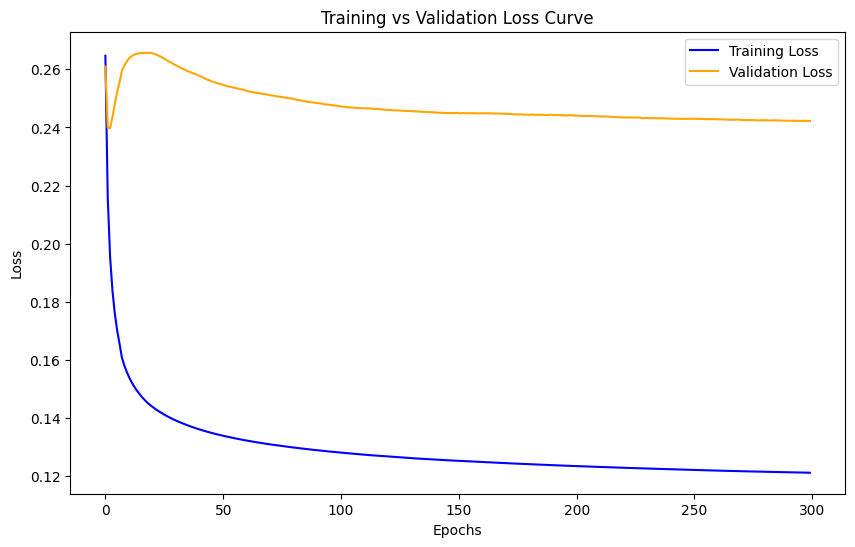

Model saved as models/mlp_11.pkl

===Testing results===
Accuracy: 0.930
Precision: 0.931
Recall: 0.930
F1 score: 0.930
Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       338
           2       0.95      0.90      0.93       321
           3       0.87      0.89      0.88       346
           4       0.93      0.94      0.94       348
           5       0.93      0.92      0.93       354
           6       0.91      0.93      0.92       362

    accuracy                           0.93      2069
   macro avg       0.93      0.93      0.93      2069
weighted avg       0.93      0.93      0.93      2069



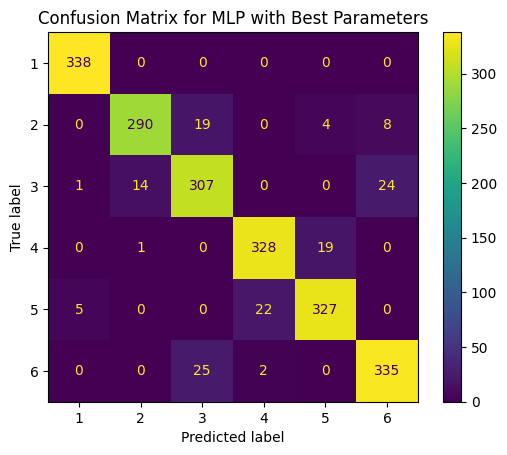

In [27]:
# Initialize MLPClassifier parameters
mlp_model = MLPClassifier(
    solver='sgd', 
    learning_rate_init=0.001, 
    learning_rate='adaptive', 
    hidden_layer_sizes=(100, 100), 
    batch_size=32, 
    alpha=0.1, 
    activation='relu', 
    max_iter=300, 
    random_state=42
)

# Set up k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k)

# Variables to store the losses
train_losses = []
val_losses = []
epochs = 300  # Number of epochs

# Train and validate on each fold
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]
    
    # Track losses for this fold
    fold_train_loss = []
    fold_val_loss = []
    
    for epoch in range(epochs):
        # Train the model for one epoch
        mlp_model.partial_fit(X_train_fold, y_train_fold, classes=np.unique(y_train))

        # Calculate the training loss (log loss for classification tasks)
        y_train_pred_proba = mlp_model.predict_proba(X_train_fold)
        y_val_pred_proba = mlp_model.predict_proba(X_val_fold)

        train_loss = log_loss(y_train_fold, y_train_pred_proba)
        val_loss = log_loss(y_val_fold, y_val_pred_proba)
        
        # Store the losses
        fold_train_loss.append(train_loss)
        fold_val_loss.append(val_loss)
    
    # Append fold losses to global lists
    train_losses.append(fold_train_loss)
    val_losses.append(fold_val_loss)

# Average the losses across all folds
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

# Plot the training vs validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), avg_train_loss, label='Training Loss', color='blue')
plt.plot(range(epochs), avg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.legend()
plt.savefig("task2_curves_mlp.png", bbox_inches='tight')
plt.show()

# Model saving process (same as before)
version = 1
model_dir = "models"  # Adjust path as necessary
while True:
    model_filename = f"mlp_{version}.pkl"
    model_path = os.path.join(model_dir, model_filename)
    if not os.path.exists(model_path):
        break
    version += 1

# Save the model
with open(model_path, 'wb') as f:
    pickle.dump({'model': mlp_model}, f)
print(f"Model saved as {model_path}\n")

# Test the model
test_model(mlp_model, X_train, y_train, X_test, y_test)

# Plot the confusion matrix for the testing set
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(mlp_model, X_test, y_test)
plt.title(f'Confusion Matrix for MLP with Best Parameters')
plt.savefig("task2_cm_mlp.png", bbox_inches='tight')
plt.show()

In [35]:
#old search results
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (100, 50), (150, 100, 50)],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'batch_size': [32, 64, 128],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Use RandomizedSearchCV to explore a random subset of the parameter grid
mlp = MLPClassifier(max_iter=300, random_state=42)
random_search_mlp = RandomizedSearchCV(mlp, mlp_param_grid, n_iter=30, cv=5, scoring='accuracy', random_state=42)
random_search_mlp.fit(X_train, y_train)

print(f"Best parameters: {random_search_mlp.best_params_}")
print(f"Test accuracy: {random_search_mlp.score(X_test, y_test)}")

Best parameters: {'solver': 'sgd', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100), 'batch_size': 32, 'alpha': 0.1, 'activation': 'relu'}
Test accuracy: 0.8624220837043634
